<a href="https://colab.research.google.com/github/sabrina-beck/masked-faces-deep-learning/blob/main/DeepLearningMaskedFaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disponibilização do Dataset

O dataset utilizado é o [Real World Masked Face Dataset](https://github.com/X-zhangyang/Real-World-Masked-Face-Dataset), optamos pela primeira opção de [download](https://github.com/X-zhangyang/Real-World-Masked-Face-Dataset) em que as amostras de imagens foram limpas e rotuladas contendo:


*   5000 faces com máscara de 525 pessoas
*   90000 faces sem máscara

Subimos uma cópia do dataset feita no dia 23/11/2020 no Google Drive [aqui](https://drive.google.com/file/d/1UD8nf8CfuEycJwt2mBjfT9ElB2QoOMlx/view?usp=sharing).

Primeiro montamos o Google Drive no ambiente do Google Colab:

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


Depois, descompactamos o dataset no ambiente do Google Colab:

In [2]:
!unzip '/content/gdrive/MyDrive/Deep-Learning/RMFD.zip' -d /content/dataset

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/dataset/self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0008.jpg  
  inflating: /content/dataset/self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0009.jpg  
  inflating: /content/dataset/self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0010.jpg  
  inflating: /content/dataset/self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0011.jpg  
  inflating: /content/dataset/self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0012.jpg  
  inflating: /content/dataset/self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0013.jpg  
  inflating: /content/dataset/self-built-masked-face-recognition-dataset/AFDB_face_dataset/zhouhuimin/1_0_zhouhuimin_0014.jpg  
  inflating: /content/dataset/self-built-mask

# Setup do Dataset

Primeiro reorganizamos a estrutura de diretórios do dataset para que tenhamos apenas dois diretórios (um para imagens com rostos sem máscara e outro para imagens com rostos com máscara).

In [3]:
from pathlib import Path

basePath = Path('/content/dataset/self-built-masked-face-recognition-dataset')
maskPath = basePath/'AFDB_masked_face_dataset'
nonMaskPath = basePath/'AFDB_face_dataset'

In [4]:
from pathlib import Path
from tqdm import tqdm
from os import listdir, rmdir, path
from shutil import move
import ntpath

def flattenClassDir(classDir, classDesc):
  classDirList = list(classDir.iterdir())
  count = 0
  for subDirectory in tqdm(classDirList, desc=classDesc):
    for imgPath in subDirectory.iterdir():
      count += 1
      filename = ntpath.basename(imgPath)
      move(imgPath, path.join(classDir, '%s.jpg' % count))
    rmdir(subDirectory)

flattenClassDir(nonMaskPath, 'non mask photos')
flattenClassDir(maskPath, 'mask photos')

mask photos: 100%|██████████| 525/525 [00:00<00:00, 5270.22it/s]


In [5]:
mask_image_count = len(list(maskPath.glob('*.jpg')))
print('Masked photos: ', mask_image_count)

non_mask_image_count = len(list(nonMaskPath.glob('*.jpg')))
print('Masked photos: ', non_mask_image_count)

Masked photos:  2203
Masked photos:  90468


Depois, usamos a lib de preprocessamento do Keras para carregar o dataset.

Note que redimensionamos as imagens para 299x299 para lidar com a rede Xception.

In [7]:
from tensorflow.keras import preprocessing

batch_size = 32
img_height = 224
img_width = 224

In [8]:
train_ds = preprocessing.image_dataset_from_directory(
  basePath,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 92671 files belonging to 2 classes.
Using 74137 files for training.


In [9]:
val_ds = preprocessing.image_dataset_from_directory(
  basePath,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 92671 files belonging to 2 classes.
Using 18534 files for validation.


In [11]:
class_names = train_ds.class_names
print('classes: ', class_names)

classes:  ['AFDB_face_dataset', 'AFDB_masked_face_dataset']


## Visualizando os dados

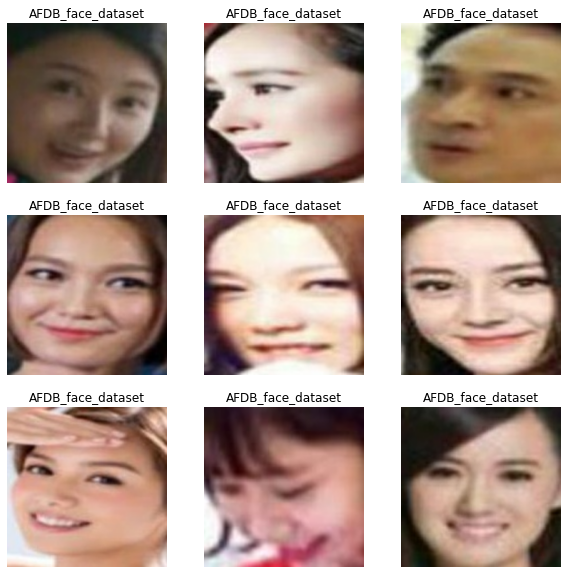

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Pré processamento pra rede escolhida


In [19]:
from tensorflow.keras.applications import resnet50
from tensorflow.data.experimental import AUTOTUNE

train_ds = train_ds.map(lambda x,y: resnet50.preprocess_input(x), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x,y: resnet50.preprocess_input(x), num_parallel_calls=AUTOTUNE)

## Congelar camadas

In [23]:
import tensorflow

# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
model = tensorflow.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))

# Congela camadas pré-treinadas
for layer in model.layers:
    layer.trainable = False

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
__________________________

In [26]:
# Insere novas camadas no fim da rede para classificação
full_model = tensorflow.keras.Sequential([
  model,
  tensorflow.keras.layers.GlobalAveragePooling2D(),
  tensorflow.keras.layers.Dense(10, activation='softmax')
])

full_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


Vamos compilar e treinar o modelo

In [32]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tensorflow.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0.001, nesterov=True)

full_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

full_model.fit(train_ds, batch_size=64, epochs=10, validation_data=val_ds)

Epoch 1/10


ValueError: ignored

In [ ]:
# Avalia o modelo na validação
score = full_model.evaluate(X_val,Y_val,verbose=1)

print('Valid loss:', score[0])
print('Valid acc:', score[1])